# Sprint 11

## SimpleConv1D

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

## [Problem 1] Creating a one-dimensional convolutional layer class that limits the number of channels to one

In [2]:
class SimpleConv1d():
    
    def forward(self, x, w, b):
        a = np.empty((len(w) - 1))
        for i in range(a.shape[0]):
            a[i] = (x[i:i + len(w)] @ w) + b[0]
        return a
    
    def backward(self, x, w, da):
        db = np.sum(da)
        
        dw = np.empty((len(w)))
        for i in range(dw.shape[0]):
            dw[i] = da @ x[i:i + len(da)]
        
        
        new_w = np.insert(w[::-1], 0, 0)
        new_w = np.append(new_w, 0)
        dx = np.empty((len(new_w) - 1))
        for i in range(dx.shape[0]):
            dx[i] = new_w[i:i + len(da)] @ da
        dx = dx[::-1]
        return db, dw, dx
    

## [Problem 2] Output size calculation after one-dimensional convolution

In [3]:
def output_size_calculation(n_in, P, F, S):
    n_out = int((n_in + 2*P - F) / S + 1)
    return n_out

## [Problem 3] Experiment of one-dimensional convolutional layer with small array

In [4]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
b = np.array([1])

In [5]:
sc1d = SimpleConv1d()
a = sc1d.forward(x, w, b)
print(a)

[35. 50.]


In [6]:
delta_a = np.array([10, 20])

In [7]:
delta_b, delta_w, delta_x = sc1d.backward(x, w, delta_a)
print(delta_b, delta_w, delta_x)

30 [ 50.  80. 110.] [ 30. 110. 170. 140.]


## [Problem 4-6]

In [8]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, *shape):
        """
        Weight initialization
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(*shape)
        return W
    
    def B(self, *shape):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(*shape)
        return B

In [9]:
class SGD:
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        Update weights and biases for a layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

In [10]:
class Conv1d:
    
    def __init__(self, b_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, s=1):
        self.b_size = b_size
        self.optimizer = optimizer
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.pa = pa
        self.s = s
        self.W = initializer.W(n_out_channels, n_in_channels, b_size)
        self.B = initializer.B(n_out_channels)
        self.n_out = None
        
    def forward(self, X):
        self.n_in = X.shape[-1]
        self.n_out = output_size_calculation(self.n_in, self.pa, self.b_size, self.s)
        X = X.reshape(self.n_in_channels, self.n_in)
        self.X = np.pad(X, ((0, 0), ((self.b_size - 1), 0)))
        self.X1 = np.zeros((self.n_in_channels, self.b_size, self.n_in + (self.b_size - 1)))
        for i in range(self.b_size):
            self.X1[:, i] = np.roll(self.X, -i, axis=-1)
        A = np.sum(self.X1[:, :, (self.b_size - 1 - self.pa):(self.n_in + self.pa)] * self.W[:, :, :, np.newaxis], axis=(1, 2)) + self.B.reshape(-1, 1)
        return A

    def backward(self, dA):
        self.dW = np.sum(np.dot(dA, self.X1[:, :, (self.b_size - 1 - self.pa):(self.n_in + self.pa), np.newaxis]), axis=-1)
        self.dB = np.sum(dA, axis=1)
        self.dA = np.pad(dA, ((0, 0), (0, (self.b_size - 1))))
        self.dA1 = np.zeros((self.n_out_channels, self.b_size, self.dA.shape[-1]))
        for i in range(self.b_size):
            self.dA1[:, i] = np.roll(self.dA, i, axis=-1)
        dX = np.sum(self.W @ self.dA1, axis=0)
        self.optimizer.update(self)
        return dX

In [11]:
c1d = Conv1d(b_size=3, initializer=SimpleInitializer(0.01), optimizer=SGD(0.01), n_in_channels=2, n_out_channels=3, pa=0, s=1)

In [12]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) #shape (2, 4), (number of input channels, number of features).
c1d.W = np.ones((3, 2, 3)) # Set to 1 for simplification of the example. (Number of output channels, number of input channels, filter size).
c1d.B = np.array([1, 2, 3]) # (Number of output channels)

In [13]:
a = c1d.forward(x)
a

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

## [Problem 7] (Advance assignment) Arbitrary number of strides

In [14]:
class Conv1dWithStride:
    
    def __init__(self, b_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, s=1):
        self.b_size = b_size
        self.optimizer = optimizer
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.pa = pa
        self.s = s
        self.W = initializer.W(n_out_channels, n_in_channels, b_size)
        self.B = initializer.B(n_out_channels)
        self.n_out = None
        
    def forward(self, X):
        self.n_samples = X.shape[0]
        self.n_in = X.shape[-1]
        self.n_out = output_size_calculation(self.n_in, self.pa, self.b_size, self.s)
        X = X.reshape(self.n_samples, self.n_in_channels, self.n_in)
        self.X = np.pad(X, ((0, 0), (0, 0), ((self.b_size - 1), 0)))
        self.X1 = np.zeros((self.n_samples, self.n_in_channels, self.b_size, self.n_in + (self.b_size - 1)))
        for i in range(self.b_size):
            self.X1[:, :, i] = np.roll(self.X, -i, axis=-1)
        A = np.sum(self.X1[:, np.newaxis, :, :, (self.b_size - 1 - self.pa):(self.n_in + self.pa):self.s] * self.W[:, :, :, np.newaxis], axis=(2, 3)) + self.B.reshape(-1, 1)
        return A

    def backward(self, dA):
        self.dW = np.sum(dA[:, :, np.newaxis, np.newaxis] * self.X1[:, np.newaxis, :, :, (self.b_size - 1 - self.pa):(self.n_in + self.pa):self.s], axis=(0, -1))
        self.dB = np.sum(dA, axis=(0, -1))
        self.dA = np.pad(dA, ((0, 0), (0, 0), (0, (self.b_size - 1))))
        self.dA1 = np.zeros((self.n_samples, self.n_out_channels, self.b_size, self.dA.shape[-1]))
        for i in range(self.b_size):
            self.dA1[:, :, i] = np.roll(self.dA, i, axis=-1)
        dX = np.sum(self.W[:, :, :, np.newaxis] * self.dA1[:, :, np.newaxis], axis=(1, 3))
        self.optimizer.update(self)
        return dX

In [15]:
c1ds = Conv1dWithStride(b_size=3, initializer=SimpleInitializer(0.01), optimizer=SGD(0.01), n_in_channels=2, n_out_channels=3, pa=0, s=1)

In [16]:
x = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]]]) #shape (2, 4), (number of input channels, number of features).
c1ds.W = np.ones((3, 2, 3)) # Set to 1 for simplification of the example. (Number of output channels, number of input channels, filter size).
c1ds.B = np.array([1, 2, 3]) # (Number of output channels)

In [17]:
a = c1ds.forward(x)
a

array([[[16., 22.],
        [17., 23.],
        [18., 24.]]])

## [Problem 8] Learning and estimation

In [18]:
class FC:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer: instance of initialization method
    optimizer: instance of optimization method
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        self.optimizer = optimizer
        self.HW = 0
        self.HB = 0
        pass
    
    def forward(self, X):
        """
        forward
        Parameters
        ----------
        X : The following forms of ndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : The following forms of ndarray, shape (batch_size, n_nodes2)
            output
        """       
        self.Z = X
        self.A = X @ self.W + self.B
        return self.A
    
    def backward(self, dA):
        """
        Backward
        Parameters
        ----------
        dA : The following forms of ndarray, shape (batch_size, n_nodes2)
            Gradient flowing from behind
        Returns
        ----------
        dZ : The following forms of ndarray, shape (batch_size, n_nodes1)
            Gradient to flow forward
        """
        self.dB = np.sum(dA, axis=0)
        self.dW = self.Z.T @ dA
        self.dZ = dA @ self.W.T
        self = self.optimizer.update(self)
        return self.dZ

In [19]:
class GetMiniBatch:
    """
    Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [20]:
class Sigmoid:
    
    def forward(self, A):
        self.A = A
        Z = 1 / (1 + np.exp(-self.A))
        return Z
    
    def backward(self, dZ):
        dA = dZ * ((1 / (1 + np.exp(-self.A))) - (1 / (1 + np.exp(-self.A))) ** 2)
        return dA

In [21]:
class Tanh:
    
    def forward(self, A):
        self.A = A
        Z = np.tanh(self.A)
        return Z
    
    def backward(self, dZ):
        dA = dZ + (1 - np.tanh(self.A) ** 2)
        return dA

In [22]:
class Softmax:
    
    def forward(self, A):
        self.Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return self.Z
    
    def backward(self, y, Z=None):
        if Z is None:
            Z = self.Z
        dA = Z - y
        loss = -np.average(np.sum(y * np.log(Z), axis=1))
        return dA, loss

In [23]:
class ReLU:
    
    def forward(self, A):
        self.A = A
        Z = np.maximum(0, A)
        return Z
    
    def backward(self, dZ):
        dA = dZ * np.where(self.A > 0, 1, 0)
        return dA

In [24]:
class XavierInitializer:
    
    def __init__(self, sigma):
        pass
    
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [25]:
class HeInitializer:
    
    def __init__(self, sigma):
        pass
    
    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [26]:
class AdaGrad:
    
    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1
        
    def update(self, layer):
        self.HW += layer.dW ** 2
        self.HB += layer.dB ** 2
        layer.W -= self.lr * np.sqrt(1 / self.HW) * layer.dW
        layer.B -= self.lr * np.sqrt(1 / self.HB) * layer.dB
        return layer

In [27]:
class ScratchCNNClassifier():
    """
    Simple three-layer CNN classifier
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self, sigma=0.01, n_features=784, n_nodes1=400, n_nodes2=200,
                 n_output=10, learning_rate=0.01, epochs=10, 
                 batch_size=32, verbose=True, optimizer=SGD,
                 activater=ReLU):
        self.verbose = verbose
        self.sigma = sigma
        self.n_features = n_features
#         self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.lr = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        
        # Update
        self.optimizer = optimizer
        self.activater = activater
        self.initializer = HeInitializer if activater == ReLU else XavierInitializer
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : The following forms of ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """
        self.train_loss = []
        self.val_loss = []
        
        
        self.Conv1d = Conv1dWithStride(b_size=7, initializer=SimpleInitializer(0.01), optimizer=self.optimizer(self.lr), n_in_channels=1, n_out_channels=1, pa=3, s=2)
        self.Conv1d.n_out = output_size_calculation(X.shape[-1], self.Conv1d.pa, self.Conv1d.b_size, self.Conv1d.s)
        self.activation1 = self.activater()
        self.FC2 = FC(self.Conv1d.n_out, self.n_nodes2, self.initializer(self.sigma), self.optimizer(self.lr))
        self.activation2 = self.activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer(self.sigma), self.optimizer(self.lr))
        self.activation3 = Softmax()
        
        for i in range(self.epochs):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            # Get batch
            for mini_X_train, mini_y_train in get_mini_batch:
                self.forward(mini_X_train)
                self.backward(mini_X_train, mini_y_train)
            
            if self.verbose:
                print(f"Epoch {i+1}:")
                self.forward(X)
                train_loss = self.activation3.backward(y, self.Z3)[1]
                self.train_loss.append(train_loss)
                print(f"train_loss: {train_loss}")
            
                if X_val is not None and y_val is not None:
                    self.forward(X_val)
                    val_loss = self.activation3.backward(y_val, self.Z3)[1]
                    self.val_loss.append(val_loss)
                    if self.verbose:
                        print(f"val_loss: {val_loss}")
    
    def predict(self, X):
        """
        Estimate using a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result
        """
        self.forward(X)
        return np.argmax(self.Z3, axis=1)
    
    def forward(self, X):
        self.A1 = self.Conv1d.forward(X)
        self.A1 = self.A1.reshape(self.A1.shape[0], self.A1.shape[-1])
        self.Z1 = self.activation1.forward(self.A1)
        self.A2 = self.FC2.forward(self.Z1)
        self.Z2 = self.activation2.forward(self.A2)
        self.A3 = self.FC3.forward(self.Z2)
        self.Z3 = self.activation3.forward(self.A3)
    
    def backward(self, X, Y):
        dA3, loss = self.activation3.backward(Y)
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dA1 = dA1[:, np.newaxis]
        dZ0 = self.Conv1d.backward(dA1)

In [28]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [29]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(48000, 784)
(48000,)
(12000, 784)
(12000,)


In [31]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])

In [32]:
SCNN = ScratchCNNClassifier(verbose=True, epochs=10, optimizer=AdaGrad, activater=ReLU)

In [33]:
SCNN.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

Epoch 1:
train_loss: 0.19950240251846568
val_loss: 0.20475360745721424
Epoch 2:
train_loss: 0.15213026100227175
val_loss: 0.1634210588613348
Epoch 3:
train_loss: 0.1256272924573344
val_loss: 0.13810969138965368
Epoch 4:
train_loss: 0.11162386777805586
val_loss: 0.12849233846239244
Epoch 5:
train_loss: 0.10081346023703697
val_loss: 0.1186870153799514
Epoch 6:
train_loss: 0.09102931968021057
val_loss: 0.11253712089303423
Epoch 7:
train_loss: 0.0852299090309255
val_loss: 0.10905039332909999
Epoch 8:
train_loss: 0.07890483326110273
val_loss: 0.10562769652786488
Epoch 9:
train_loss: 0.07201397907493129
val_loss: 0.09957932784293358
Epoch 10:
train_loss: 0.06783803348275294
val_loss: 0.09735316046755285


In [34]:
y_train_pred = SCNN.predict(X_train)
y_val_pred = SCNN.predict(X_val)
print(y_train, y_train_pred)
print(y_val, y_val_pred)

[3 3 4 ... 0 7 5] [3 3 4 ... 0 7 5]
[1 3 9 ... 0 1 2] [1 3 7 ... 0 1 2]


In [35]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4721
           1       0.98      0.99      0.99      5441
           2       0.98      0.98      0.98      4765
           3       0.98      0.97      0.98      4882
           4       0.98      0.97      0.98      4635
           5       0.98      0.98      0.98      4360
           6       0.99      0.99      0.99      4740
           7       0.98      0.98      0.98      5021
           8       0.98      0.97      0.97      4646
           9       0.96      0.97      0.97      4789

    accuracy                           0.98     48000
   macro avg       0.98      0.98      0.98     48000
weighted avg       0.98      0.98      0.98     48000



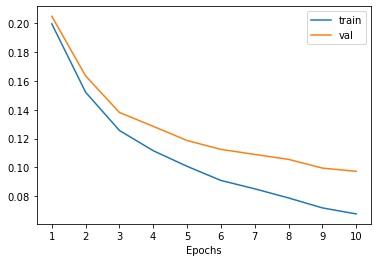

In [37]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, SCNN.epochs+1), SCNN.train_loss, label='train')
plt.plot(np.arange(1, SCNN.epochs+1), SCNN.val_loss, label='val')
plt.xlabel('Epochs')
plt.xticks(np.arange(1, SCNN.epochs+1))
plt.legend()
plt.show()